
# Taks 1: INT303 A1

The codes for Task 1:

**XJTLU**<br>
**Name:** Chuanxin Zhai  <br>
**ID:** 1929631 <br>

In [1]:
# All the code for Task 1 in one cell.
# Explain your code with comments.

from IPython.display import HTML
import numpy as np
import urllib.request
import bs4 #this is beautiful soup
import time
#import operator
#import socket
#import cPickle
import os
import csv
import html
import threading

import re # regular expressions
from bs4 import BeautifulSoup

import requests
from pandas import Series
import pandas as pd
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")





def get_page_book_urls(url): 
    res = requests.get(url)
    res = res.text.replace(" ", "").replace("\n", "")  #
    book_urls = re.findall(r'<divclass="image_container"><ahref="([a-zA-Z-\_0-9/\.]+)">', res)
    page_books = []
    if len(book_urls) != 20:
        raise ValueError("Pages less than 20 books, parsing error possible")  
    for book_url in book_urls:
        book_url = f"http://books.toscrape.com/catalogue/{book_url}"
        page_books.append(book_url)
    return page_books

book_urls = get_page_book_urls("http://books.toscrape.com/catalogue/page-1.html")
print(book_urls)

def get_author(name:str) -> str:
    url = f"https://www.goodreads.com/search?q={name}"  
    proxies = {"http": "127.0.0.1:7890", "https": "127.0.0.1:7890"}  
    data = requests.get(url, proxies=proxies).content.decode('utf-8') 
    data = html.unescape(data)  
    author = re.findall(r'<span itemprop="name">([^<]+)</span></a>', data) 
    if len(author) == 0: 
        return "None"
    return author[0]
name = "A Light in the Attic"
author = get_author(name)
print("A Light in the Attic's author is'：", author)


book_url = book_urls[0]
print("the first page of first books url:", book_url)
def get_book_info(book_url):
    info_resp = requests.get(book_url).content.decode('utf-8').replace("\n", "")
    info_resp = html.unescape(info_resp)
    strinfo = re.compile(">[ \n]+<")
    info_resp = strinfo.sub("><", info_resp)  
    
    name = re.findall('product_main"><h1>(.+)</h1><p class="price_color">', info_resp)[0]
    book_category = re.findall(r'">([^<]+)</a></li><li class="active">', info_resp)[0]
    Prices = re.findall(r'class="price_color">£([0-9\.]+)</p><p class="instock availability">', info_resp)[0]
    Ratings = re.findall("star-rating ([a-zA-Z]+)", info_resp)[0]

    Description = re.findall('<h2>Product Description</h2></div><p>(.+)</p><div class="sub-header">', info_resp)
    if len(Description) == 0:  
        Description = ""
    else:
        Description = Description[0]
    table_info = re.findall(r'<table class="table table-striped">(.+)</table>', info_resp)[0]
    number_of_reviews = re.findall(r"<tr><th>Number of reviews</th><td>([0-9]+)</td></tr>", table_info)[0]
    availability = re.findall("<tr><th>Availability</th><td>([^<]+)</td></tr>", table_info)[0] 
    availability = re.findall('In stock \(([0-9]+) available\)', availability)[0]  
    product_type = re.findall("<tr><th>Product Type</th><td>([a-zA-Z]+)</td></tr>", table_info)[0]
    author = get_author(name)
    book = {
        "Title of Book": name,
        "author": author,  
        "Number of reviews": number_of_reviews,
        "Rating": Ratings.replace("One", "1").replace("Two", "2").replace("Three", "3").replace("Four", "4").replace("Five", "5"),
        "Price":  Prices,
        "Product Type": product_type,
        "Book category": book_category,
        "availability": availability,
        "Description": Description,
    }
    return book

book_info = get_book_info(book_url)
print("the first page information of the first book: ")
for key, value in book_info.items():
    print(key,": ", value)




def write_book_to_csv(filename):
    '''
    To prevent network interruption by crawling 1000 books and writing them into filename.csv file, you can continue to crawl from breakpoints
    :param filename: The name of the final saved file
    '''
    page_start = 1 
    page_end = 50  
    if not os.path.exists("MyScrap"):  
        os.mkdir("MyScrap")
    for i in range(page_start, page_end + 1):
        tempfilename = f"MyScrap/scrap{i}.csv"
        if os.path.exists(tempfilename):
            continue 
        page_url = f"http://books.toscrape.com/catalogue/page-{i}.html"
        
        def scrapt_task(page_url, tempfilename):  
            print(f"begin scrape first page{page_url}")
            book_urls = get_page_book_urls(page_url) 
            page_books = [] 
            for book_url in book_urls: 
                book = get_book_info(book_url)
                page_books.append(book)
            print(f"scrape page successfully{page_url}")
            with open(tempfilename, "w", encoding='utf-8', newline='') as f: 
                csv_writer = csv.writer(f)
                csv_writer.writerow(["Title of Book", "author", "Number of reviews", "Rating", "Price", "Product Type", "Book category", "availability", "Description" ])
                for book in page_books:
                    csv_writer.writerow(book.values())

        if len(threading.enumerate()) <= 5:  
            threading.Thread(target=scrapt_task, args=(page_url,tempfilename )).start()  
        else:
            scrapt_task(page_url, tempfilename) 
    while True:  
        flag = True
        for i in range(1, 51): 
            tempfilename = f"MyScrap/scrap{i}.csv"
            if not os.path.exists(tempfilename):
                flag = False
        if flag:
            break
        time.sleep(3)
    print("A thousand books have been climbed！")
    with open(filename, "w", encoding='utf-8', newline="") as f:  
        csv_writer = csv.writer(f)
        csv_writer.writerow(
            ["Title of Book", "author", "Number of reviews", "Rating", "Price", "Product Type", "Book category",
             "availability", "Description"])
        for i in range(1, 51):
            with open(f"MyScrap/scrap{i}.csv", "r", encoding='utf-8') as tempf:
                csv_reader = csv.reader(tempf)
                csv_reader = list(csv_reader)
                for e in csv_reader[1:]:
                    csv_writer.writerow(e)

filename = "chuanxin.zhai 1929631.csv"
if os.path.exists(filename): 
    print("The crawling file exists. Procedure!")
else:
    print("An existing file crawl multithread starts to crawl ing")
    write_book_to_csv(filename)








    
    

    
    
    
    





['http://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html', 'http://books.toscrape.com/catalogue/tipping-the-velvet_999/index.html', 'http://books.toscrape.com/catalogue/soumission_998/index.html', 'http://books.toscrape.com/catalogue/sharp-objects_997/index.html', 'http://books.toscrape.com/catalogue/sapiens-a-brief-history-of-humankind_996/index.html', 'http://books.toscrape.com/catalogue/the-requiem-red_995/index.html', 'http://books.toscrape.com/catalogue/the-dirty-little-secrets-of-getting-your-dream-job_994/index.html', 'http://books.toscrape.com/catalogue/the-coming-woman-a-novel-based-on-the-life-of-the-infamous-feminist-victoria-woodhull_993/index.html', 'http://books.toscrape.com/catalogue/the-boys-in-the-boat-nine-americans-and-their-epic-quest-for-gold-at-the-1936-berlin-olympics_992/index.html', 'http://books.toscrape.com/catalogue/the-black-maria_991/index.html', 'http://books.toscrape.com/catalogue/starving-hearts-triangular-trade-trilogy-1_990/index.htm

# Task 2

# Topic: Exploring the relationship between the price of books and other factors

# Introduction
The writer Gorky once said that books are the ladder of progress for people. There is a very large variety of books on the market today. However, there are still many factors that influence consumers to buy books besides price. As one of a consumer, I want to explore the relationship between the price of books and other factors.In this way, consumers can refer to the impact of these factors on the price of books when buying them later, to help them better choose the suitable items for them.



### Methods (5 figures should be around the same topic)
To explore the relationship between other factors and price, I used price as a benchmark to compare price with other factors such as rating, book category, and number of books in stock etc. I use different types of charts to visualize the data, making the relationship more intuitive.

In [2]:
import pandas as pd

data = pd.read_csv('chuanxin.zhai 1929631.csv')
data

,Title of Book,author,Number of reviews,Rating,Price,Product Type,Book category,availability,Description
0,A Light in the Attic,Shel Silverstein,0,3,51.77,Books,Poetry,22,It's hard to imagine a world without A Light i...
1,Tipping the Velvet,Sarah Waters,0,1,53.74,Books,Historical Fiction,20,"""Erotic and absorbing...Written with starling ..."
2,Soumission,Michel Houellebecq,0,1,50.10,Books,Fiction,20,"Dans une France assez proche de la nôtre, un h..."
3,Sharp Objects,Gillian Flynn,0,4,47.82,Books,Mystery,20,"WICKED above her hipbone, GIRL across her hear..."
4,Sapiens: A Brief History of Humankind,Yuval Noah Harari,0,5,54.23,Books,History,20,From a renowned historian comes a groundbreaki...
...,...,...,...,...,...,...,...,...,...
995,Alice in Wonderland (Alice's Adventures in Won...,Lewis Carroll,0,1,55.53,Books,Classics,1,NaN
996,"Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)",Gamon Sakurai,0,4,57.06,Books,Sequential Art,1,High school student Kei Nagai is struck dead i...
997,A Spy's Devotion (The Regency Spies of London #1),Melanie Dickerson,0,5,16.97,Books,Historical Fiction,1,"In England’s Regency era, manners and elegance..."
998,1st to Die (Women's Murder Club #1),James Patterson,0,1,53.98,Books,Mystery,1,"James Patterson, bestselling author of the Ale..."


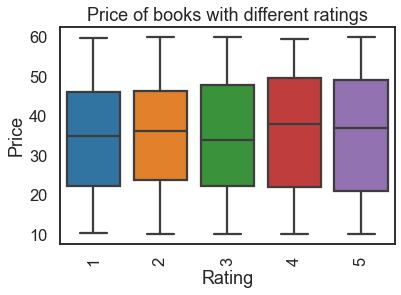

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x="Rating", y="Price", data=data)
plt.title('Price of books with different ratings')
plt.xticks(rotation = 90)
plt.show()

### Conclusion between price and ratings:
From the chart above, we find that the higher the rating, the wider the range of price ranges covered. It means that even with a rating of five (full scores), there are books with very low prices and also books with very high prices. In other word, we can't judge prices by how high or low they are rated. There is no obvious relationship between price and ratings.

In [4]:
data_ = data.groupby('Book category')['Price'].mean().sort_values()
data_

Book category
Crime                 10.970000
Academic              13.120000
Adult Fiction         15.360000
Paranormal            15.400000
Erotica               19.190000
Historical            22.830000
Food and Drink        31.414667
Thriller              31.433636
Mystery               31.719062
Business              32.460000
Religion              32.567143
Childrens             32.638276
Science               33.088571
Humor                 33.501000
Philosophy            33.558182
Historical Fiction    33.644231
Biography             33.662000
Science Fiction       33.802500
Romance               33.933714
Psychology            34.218571
Nonfiction            34.260182
Christian Fiction     34.385000
Default               34.392697
Sequential Art        34.572267
Spirituality          35.098333
Young Adult           35.449074
Music                 35.636923
Add a comment         35.796418
Short Stories         35.880000
Horror                35.949412
Poetry                35.9

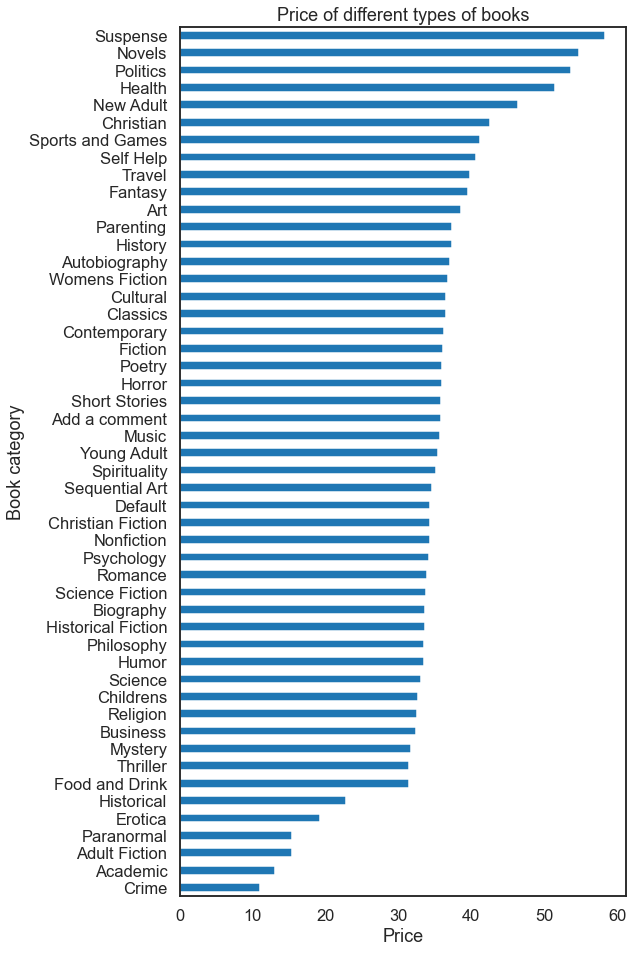

In [5]:
plt.figure(figsize = (8,16))
data_.plot(kind = 'barh')
plt.title('Price of different types of books')
plt.xlabel('Price')
plt.show()

### Conclusion between price and book category
From the bar chart above, it is easy to find the average price of crime books is very low. Book category including academic, adult fiction, paranormal and erotica is low, lower than 20. However, the average price of suspense, novels, politics and health books is extremely high, more than 50. It means that there is clear relationship between price and book category.

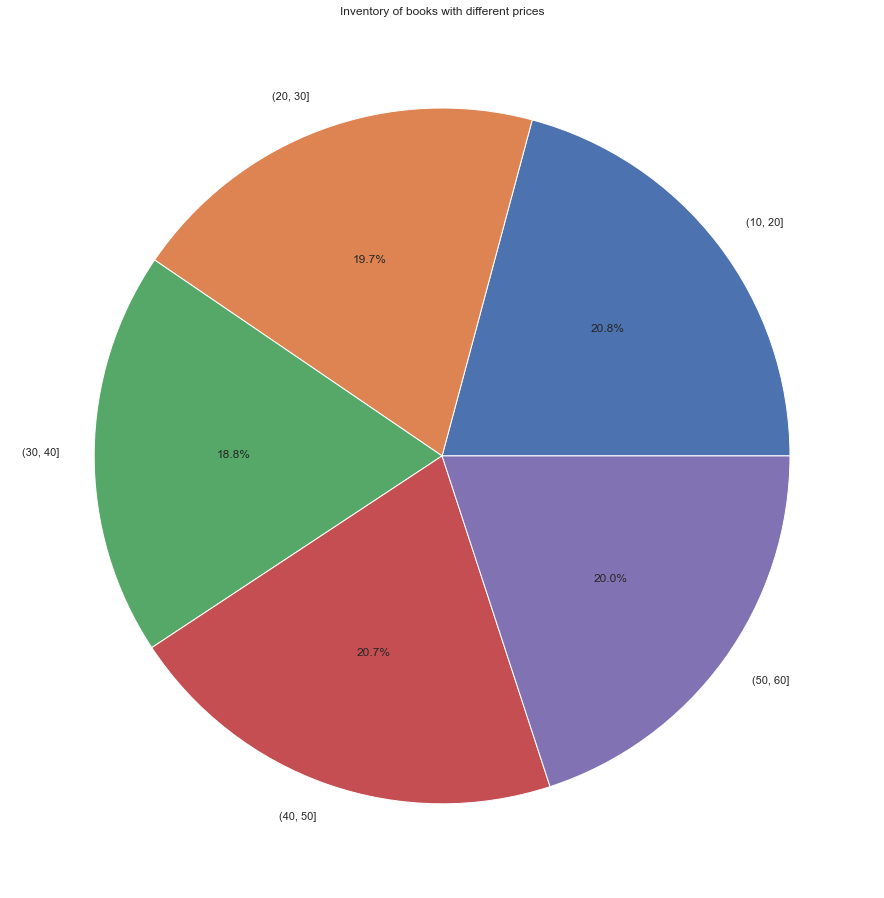

In [15]:
bins = [10,20,30,40,50,60]
data['Price Cut'] = pd.cut(data['Price'],bins = bins)
data_ = data.groupby('Price Cut')['availability'].sum()
data_
plt.figure(figsize=(16,16))

data_.plot(kind = 'pie',autopct='%.1f%%')
plt.title('Inventory of books with different prices')
plt.ylabel('')
plt.show()

### Conclusion between price and availablilty
The pie chart above shows the percentage of availability (stock numbers) and price. We easily find the price between 10-20 takes the maximum percentage, 20.8% while the price between 30-40 takes the minimun percentage, 18.8%. However, the difference between the maximum and minimum value is only 2%. In other word, the relationship between price and availability is not very influential.

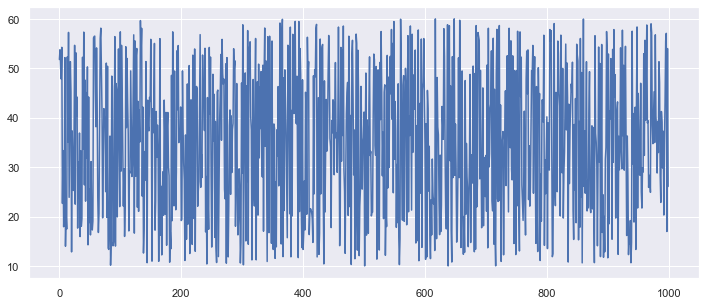

In [13]:
sns.set()
plt.figure(figsize=(12, 5))
plt.plot(data.Price)
plt.show()

### Conclusion between price and price range
The chart above is about price density, showing the price range during the 1 thousand books. It is easily find that most books of price are priced in the 30 to 40 range.

### Conlusion between price and number of reviews, product type.
By spidering the number of reviews and product type, we find that the number of reviews of all book are 0,while the product type is only book. Therefore, we cannot explore the relationship between prices and number of reviews, product type.

### Conlusion between price and author, description
Forced by my limited knowledge, I cannot analyse which book's author is more famous, nor can I compare which book's introduction is more appealing through natural language processing. Hence, we will not explore the relationship between prices and author, description here.

# Sum up
That is the end of Task 2. In conclusion, we discuss 8 factors that might influce the price. Through data analysis, we find that ratings and availability (number of stocks) have a relatively small effect on price, but the book category has a larger effect on price. Most books of price are priced in the 30 to 40 range. However, we couldnot explore the impact of other factors including number of reviews, product type, author and description on price.